In [3]:
import pandas as pd
import sklearn 
import scipy
from scipy.stats import shapiro
from sklearn import linear_model as lm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge , ElasticNet, LogisticRegression, lars_path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, IsolationForest
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
import seaborn as sns
import statsmodels.api as sm
import statsmodels
from statsmodels import graphics
from statsmodels.graphics.gofplots import qqplot
import datetime
from datetime import timedelta, time

/Users/giancarlokerg/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
sklearn.__version__

'0.18.1'

In [5]:
df_day = pd.read_csv("day.csv")

In [6]:
df_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


--------
# **GAME PLAN** 

Let us first try to build a model for "cnt" in the daily dataset and then we can finetune things for the hourly "cnt". 
We will try to build two models: one for the "casual cnt" as well as for the "registered cnt", and then add them up later on.  

--------

## **A - First round**
    
### **A1 - _Data preparation_**: 
watch out for missing values, normalize continuous features, convert categorical features to one-hot encoding via pd.get_dummies

### **A2 - _Plots_**: 
we want to understand how different features impact the outcome
    
### **A3 - _First round model testing_**: 
based on previous plots, run some basic models. Two main families of models will be tested: linear models, tree-based models.

--------    

## **B - Second round**

### **B1 - _Outlier removal_**: 
such as storm sandy hitting DC at the end of october 2012. This can be done via expert knowledge or clustering.

### **B2 - _Second round model testing_**

--------

## **C - Third round **

### **C1 - Feature engineering**: 
adding more iteractive features, getting rid of redundant features. use lasso with various paramter "alpha" (the parameter that determines how aggressively features are being pushed towards 0 - so the larger alpha is, the less features will be used with the crosseponding lasso model). segment features according to how much leverage they have on each label (casual as well as registered): high leverage features, medium leverage features, low leverage features. then build intuition through various plots.

### **C2 - Third round model testing**

--------

## **D - Fourth round**

### **D1 - Feature augmentation from external sources**: 
such as pulling data for **daylight timespan**

### **D2 - Fourth round model testing**
--------

# A - First round

## A1- Data preparation 

In [7]:
df_day.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

**continuous features**: 'temp', 'atemp', 'hum', 'windspeed'

**categorical features**: 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',

In [8]:
pd.isnull(df_day).sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

## transforming categorical features

In [9]:
dummies_season = pd.get_dummies(df_day['season']).rename(columns={1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"})
dummies_yr = pd.get_dummies(df_day['yr']).rename(columns={0: "year 2011", 1: "year 2012"})
dummies_mnth = pd.get_dummies(df_day['mnth']).rename(columns={1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"})
dummies_holiday = pd.get_dummies(df_day['holiday']).rename(columns={0: "holiday", 1: "non holiday"})
dummies_weekday = pd.get_dummies(df_day['weekday']).rename(columns={0: "Sunday", 1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday"})
dummies_workingday = pd.get_dummies(df_day['workingday']).rename(columns={0: "workingday", 1: "non workingday"})
dummies_weathersit = pd.get_dummies(df_day['weathersit']).rename(columns={1: "weathersit 1", 2: "weathersit 2", 3: "weathersit 3", 4: "weathersit 4"})
dummy_features = pd.concat([dummies_season,dummies_yr,dummies_mnth, dummies_holiday,dummies_weekday,dummies_workingday,dummies_weathersit],axis=1)

In [10]:
cont_features= df_day[['temp', 'atemp', 'hum', 'windspeed']]

## **A2 - Some plots** 

### examination of some categorical data

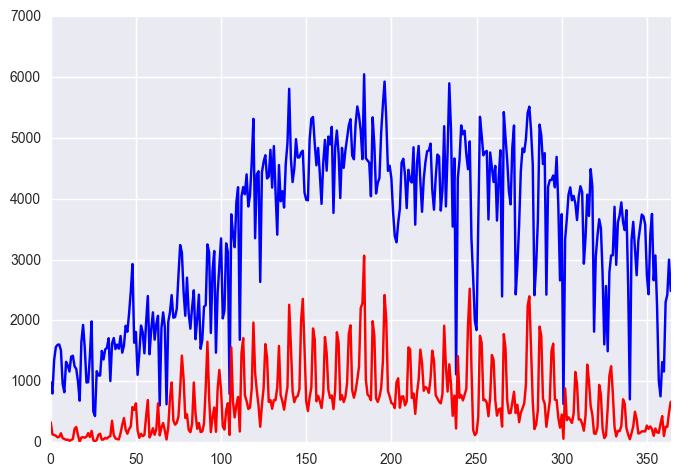

In [11]:
y=0
df_day['cnt'][df_day['yr']== y].plot(kind = 'line',color='blue')
df_day['casual'][df_day['yr']== y].plot(kind = 'line', color = 'r')

In [12]:
def log_transform(x):
    return np.log(x+1)

In [13]:
df_day['log cnt'] = df_day['cnt'].apply(log_transform)
df_day['log casual'] = df_day['casual'].apply(log_transform)
df_day['log registered'] = df_day['registered'].apply(log_transform)

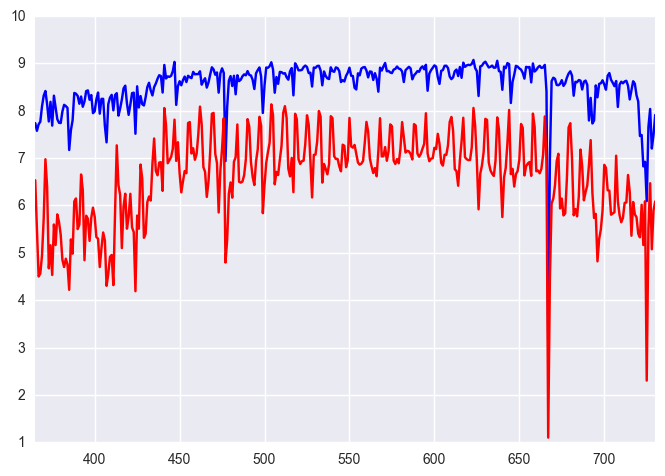

In [14]:
y = 1 
df_day['log cnt'][df_day['yr']== y].plot(kind = 'line',color='blue')
df_day['log casual'][df_day['yr']== y].plot(kind = 'line', color = 'r')

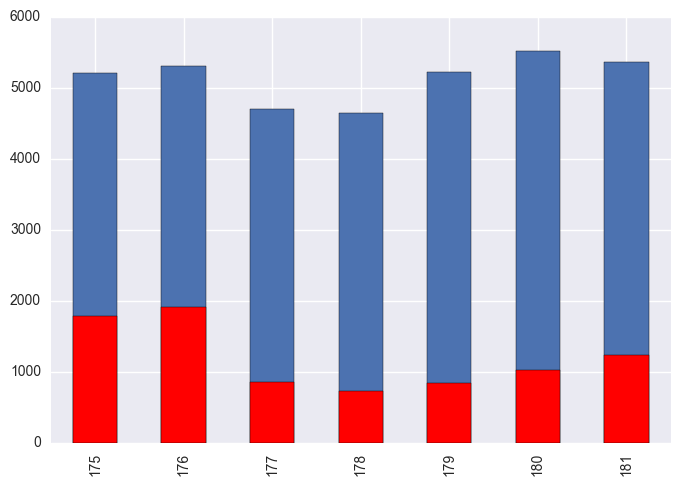

In [15]:
week = 25
df_day['cnt'][7*week:7*week+ 7].plot(kind='bar')
df_day['casual'][7*week:7*week+ 7].plot(kind='bar', color = 'r')

there doesnt seem to be an obvious trend within the week. however as we keep increasing the `week` parameter we notice an increase of number of rented bikes for warmer season. thus we conclude temperature, weathersit and season must play a role. 

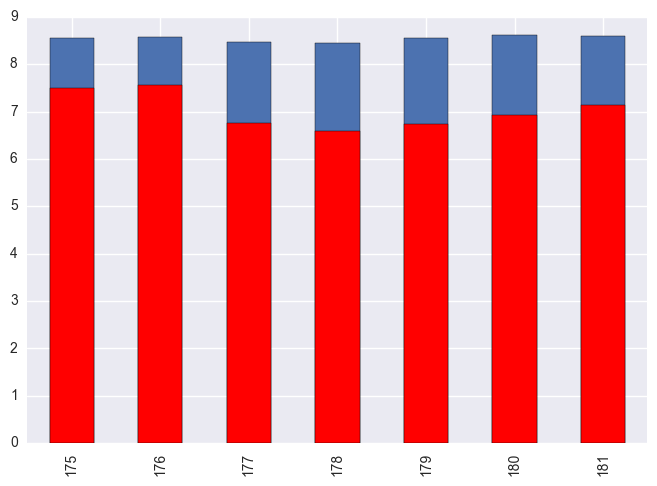

In [16]:
week = 25
df_day['log cnt'][7*week:7*week+ 7].plot(kind='bar')
df_day['log casual'][7*week:7*week+ 7].plot(kind='bar', color = 'r')

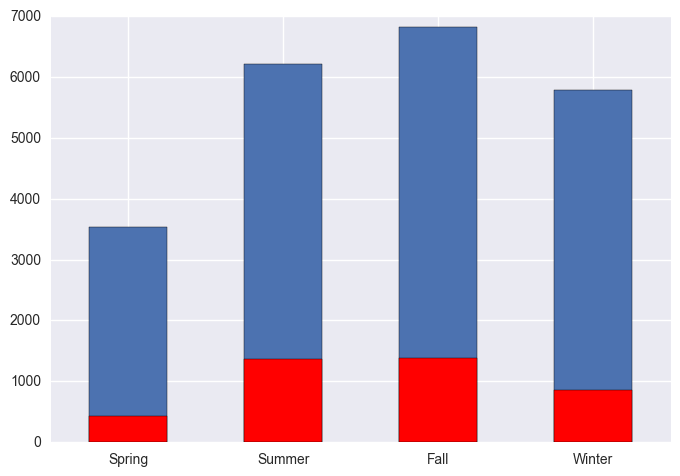

In [17]:
y = 1
pd.Series([df_day['cnt'][(df_day['season'] == 1)&(df_day['yr'] == y)].mean(),  df_day['cnt'][(df_day['season'] == 2)&(df_day['yr'] == y)].mean(), df_day['cnt'][(df_day['season'] == 3)&(df_day['yr'] == y)].mean(), df_day['cnt'][(df_day['season'] == 4)&(df_day['yr'] == y)].mean()], index = ["Spring","Summer","Fall","Winter"]).plot(kind = 'bar', rot = 0) 
pd.Series([df_day['casual'][(df_day['season'] == 1)&(df_day['yr'] == y)].mean(),  df_day['casual'][(df_day['season'] == 2)&(df_day['yr'] == y)].mean(), df_day['casual'][(df_day['season'] == 3)&(df_day['yr'] == y)].mean(), df_day['casual'][(df_day['season'] == 4)&(df_day['yr'] == y)].mean()], index = ["Spring","Summer","Fall","Winter"]).plot(kind = 'bar', rot = 0, color ='r') 

we see that most total bike shares happen in Fall, while the difference between summer and fall is minimal for casual ones.

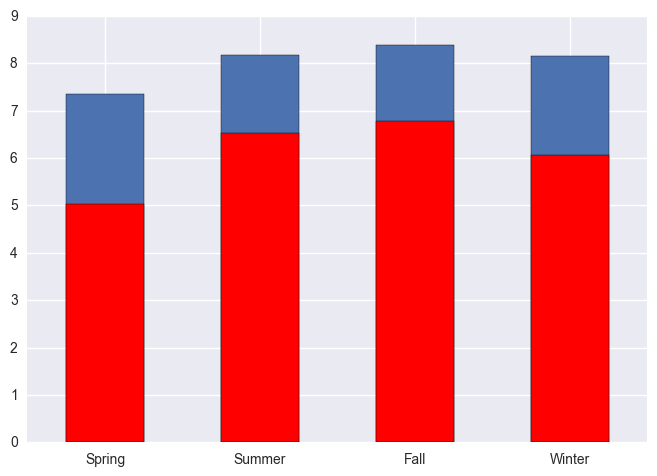

In [18]:
y = 0
pd.Series([df_day['log cnt'][(df_day['season'] == 1)&(df_day['yr'] == y)].mean(),  df_day['log cnt'][(df_day['season'] == 2)&(df_day['yr'] == y)].mean(), df_day['log cnt'][(df_day['season'] == 3)&(df_day['yr'] == y)].mean(), df_day['log cnt'][(df_day['season'] == 4)&(df_day['yr'] == y)].mean()], index = ["Spring","Summer","Fall","Winter"]).plot(kind = 'bar', rot = 0) 
pd.Series([df_day['log casual'][(df_day['season'] == 1)&(df_day['yr'] == y)].mean(),  df_day['log casual'][(df_day['season'] == 2)&(df_day['yr'] == y)].mean(), df_day['log casual'][(df_day['season'] == 3)&(df_day['yr'] == y)].mean(), df_day['log casual'][(df_day['season'] == 4)&(df_day['yr'] == y)].mean()], index = ["Spring","Summer","Fall","Winter"]).plot(kind = 'bar', rot = 0, color ='r') 

### examination of some continuous data

In [19]:
df_day[['temp','atemp','hum','windspeed','casual','registered','cnt']].describe()

,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


#### a - 'temp'

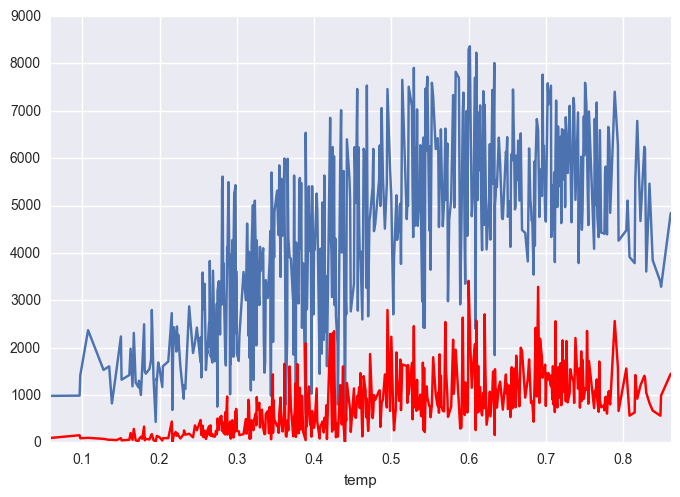

In [20]:
df_day.groupby(['temp'])['cnt'].mean().plot(kind = 'line')
df_day.groupby(['temp'])['casual'].mean().plot(kind = 'line', color = 'r')

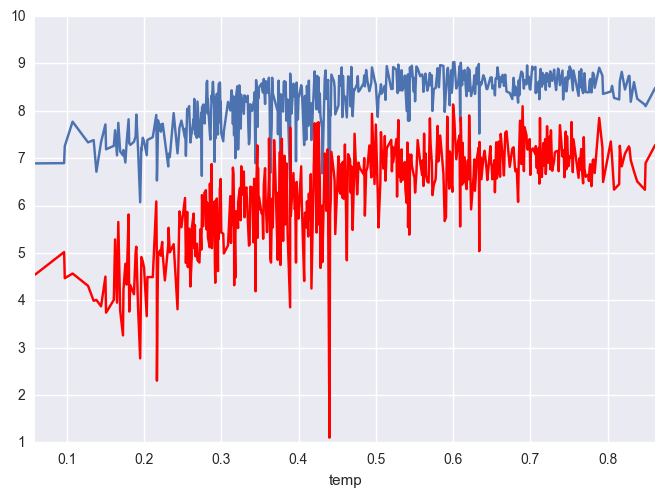

In [21]:
df_day.groupby(['temp'])['log cnt'].mean().plot(kind = 'line')
df_day.groupby(['temp'])['log casual'].mean().plot(kind = 'line', color = 'r')

it looks like if we want to use linear models, it might be better to use the log transform on the labels. this is a standard procedure as count data often behaves like a **Poisson distribution**.

#### b - 'atemp'

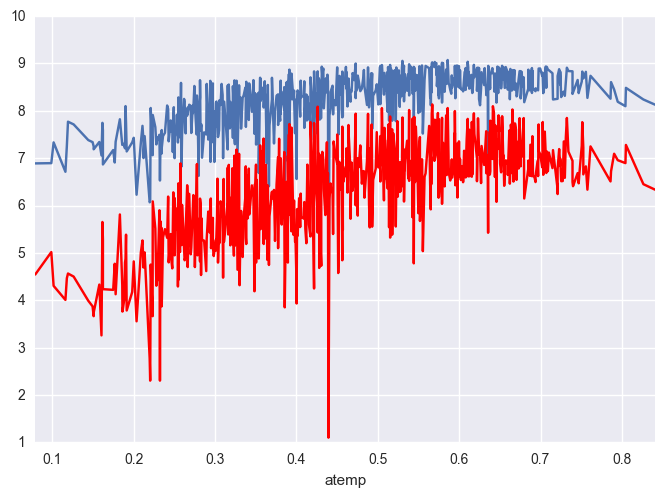

In [22]:
df_day.groupby(['atemp'])['log cnt'].mean().plot(kind = 'line')
df_day.groupby(['atemp'])['log casual'].mean().plot(kind = 'line', color = 'r')

#### c - 'windspeed'

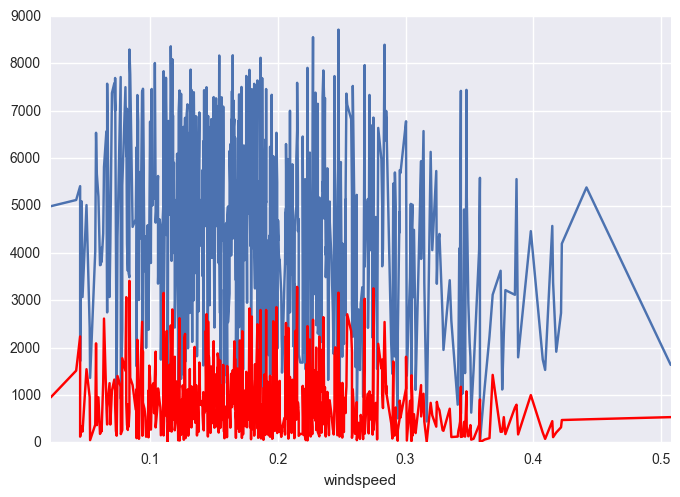

In [23]:
df_day.groupby(['windspeed'])['cnt'].mean().plot(kind = 'line')
df_day.groupby(['windspeed'])['casual'].mean().plot(kind = 'line', color = 'r')

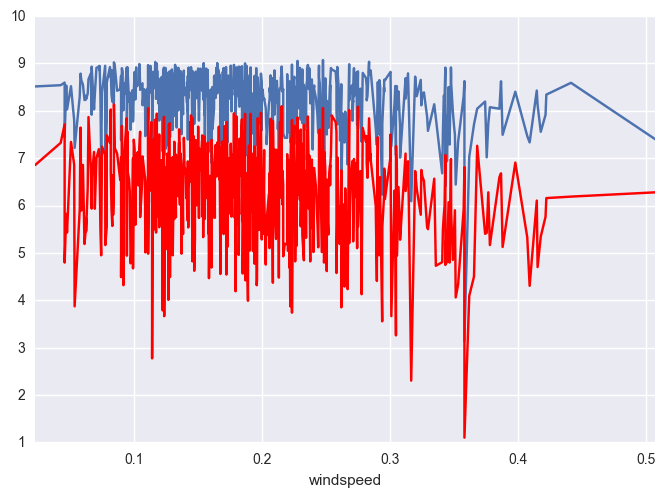

In [24]:
df_day.groupby(['windspeed'])['log cnt'].mean().plot(kind = 'line')
df_day.groupby(['windspeed'])['log casual'].mean().plot(kind = 'line', color = 'r')

#### d - 'hum'

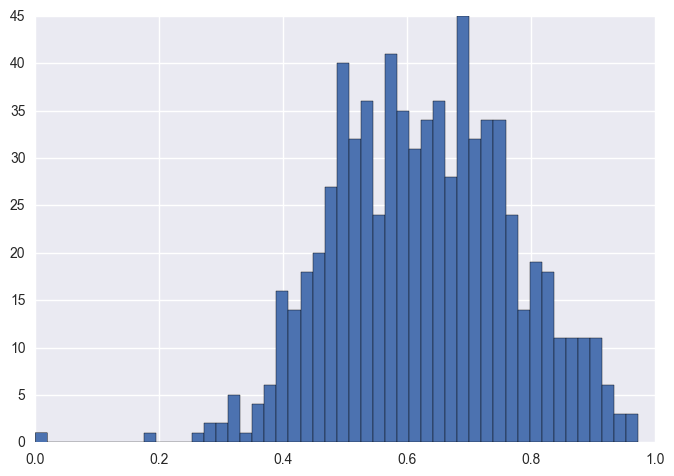

In [25]:
df_day['hum'].hist(bins=50)

In [26]:
scipy.stats.shapiro(df_day['hum'])

(0.9933457970619202, 0.0024830217007547617)

In [27]:
df_day['log hum'] = df_day['hum'].apply(log_transform)

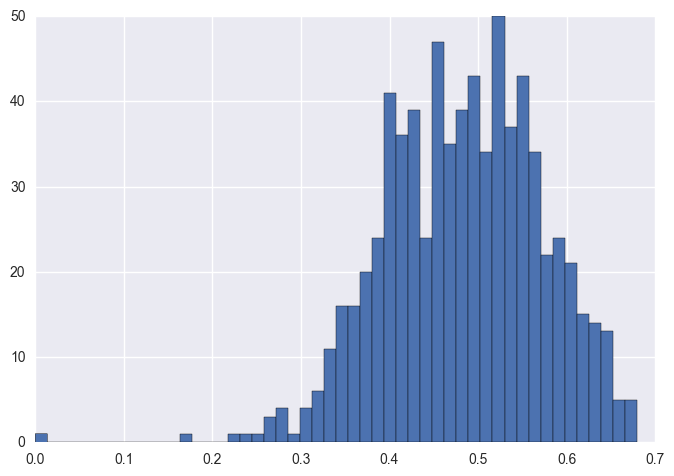

In [28]:
df_day['log hum'].hist(bins=50)

In [29]:
scipy.stats.shapiro(df_day['log hum'])

(0.9862949848175049, 2.3785437406331766e-06)

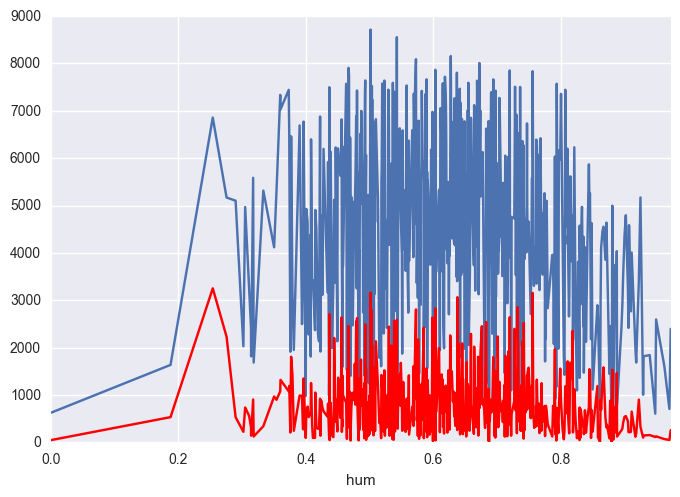

In [30]:
df_day.groupby(['hum'])['cnt'].mean().plot(kind = 'line')
df_day.groupby(['hum'])['casual'].mean().plot(kind = 'line', color = 'r')

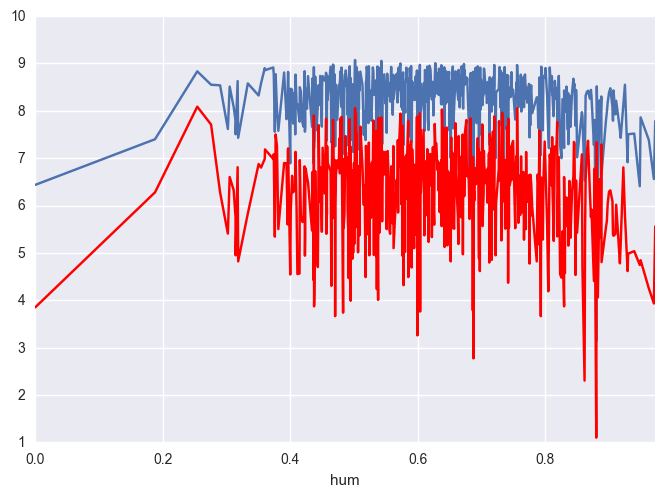

In [31]:
df_day.groupby(['hum'])['log cnt'].mean().plot(kind = 'line')
df_day.groupby(['hum'])['log casual'].mean().plot(kind = 'line', color = 'r')

In [30]:
cont_features.corr()

,temp,atemp,hum,windspeed
temp,1.000000,0.991702,0.126963,-0.157944
atemp,0.991702,1.000000,0.139988,-0.183643
hum,0.126963,0.139988,1.000000,-0.248489
windspeed,-0.157944,-0.183643,-0.248489,1.000000


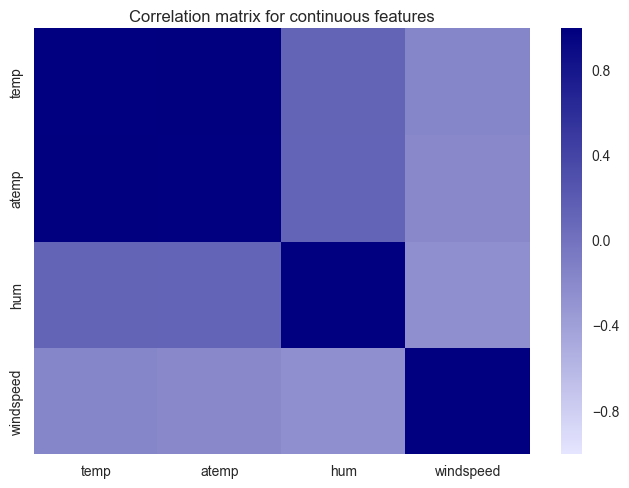

In [31]:
blu = sns.light_palette("navy", as_cmap= True)
sns.heatmap(cont_features.corr(),cmap= blu, fmt="%d")
plt.title("Correlation matrix for continuous features")

In [32]:
correlation_dataframe = pd.concat([cont_features, dummy_features, df_day[['cnt','casual','registered']] ],axis = 1).corr()

In [33]:
def more_than_80_percent(x):
    return (x > 0.8)

def more_than_60_percent(x):
    return (x > 0.6)

def more_than_40_percent(x):
    return (x > 0.4)

In [34]:
correlation_dataframe.apply(more_than_80_percent).sum()

temp              2
atemp             2
hum               1
windspeed         1
Spring            1
Summer            1
Fall              1
Winter            1
year 2011         1
year 2012         1
Jan               1
Feb               1
Mar               1
Apr               1
May               1
Jun               1
Jul               1
Aug               1
Sep               1
Oct               1
Nov               1
Dec               1
holiday           1
non holiday       1
Sunday            1
Monday            1
Tuesday           1
Wednesday         1
Thursday          1
Friday            1
Saturday          1
workingday        1
non workingday    1
weathersit 1      1
weathersit 2      1
weathersit 3      1
cnt               2
casual            1
registered        2
dtype: int64

the only strong correlation there is between 'registered' and 'cnt' as well as between 'atemp' and 'temp', which is pretty much common sense. Lets us watch out for more non obvious correlations. 

In [35]:
correlation_dataframe.apply(more_than_60_percent).sum()

temp              4
atemp             4
hum               1
windspeed         1
Spring            1
Summer            1
Fall              3
Winter            1
year 2011         1
year 2012         1
Jan               1
Feb               1
Mar               1
Apr               1
May               1
Jun               1
Jul               1
Aug               1
Sep               1
Oct               1
Nov               1
Dec               1
holiday           1
non holiday       1
Sunday            2
Monday            1
Tuesday           1
Wednesday         1
Thursday          1
Friday            1
Saturday          2
workingday        3
non workingday    1
weathersit 1      1
weathersit 2      1
weathersit 3      1
cnt               5
casual            2
registered        2
dtype: int64

In [36]:
correlation_dataframe[correlation_dataframe.apply(more_than_60_percent).sum() > 1].index

Index(['temp', 'atemp', 'Fall', 'Sunday', 'Saturday', 'workingday', 'cnt',
       'casual', 'registered'],
      dtype='object')

In [37]:
df_allvalues = pd.concat([cont_features, dummy_features, df_day[['cnt','casual','registered']] ],axis = 1)

In [38]:
df_allvalues[correlation_dataframe[correlation_dataframe.apply(more_than_60_percent).sum() > 1].index].corr()

,temp,atemp,Fall,Sunday,Saturday,workingday,cnt,casual,registered
temp,1.000000,0.991702,0.678471,-0.026323,-0.029882,-0.052660,0.627494,0.543285,0.540012
atemp,0.991702,1.000000,0.655956,-0.022801,-0.030889,-0.052182,0.631066,0.543864,0.544192
Fall,0.678471,0.655956,1.000000,-0.008961,-0.000037,-0.016218,0.346487,0.303945,0.296440
Sunday,-0.026323,-0.022801,-0.008961,1.000000,-0.167732,0.602541,-0.058288,0.292542,-0.201110
Saturday,-0.029882,-0.030889,-0.000037,-0.167732,1.000000,0.602541,0.009773,0.368323,-0.149954
workingday,-0.052660,-0.052182,-0.016218,0.602541,0.602541,1.000000,-0.061156,0.518044,-0.303907
cnt,0.627494,0.631066,0.346487,-0.058288,0.009773,-0.061156,1.000000,0.672804,0.945517
casual,0.543285,0.543864,0.303945,0.292542,0.368323,0.518044,0.672804,1.000000,0.395282
registered,0.540012,0.544192,0.296440,-0.201110,-0.149954,-0.303907,0.945517,0.395282,1.000000


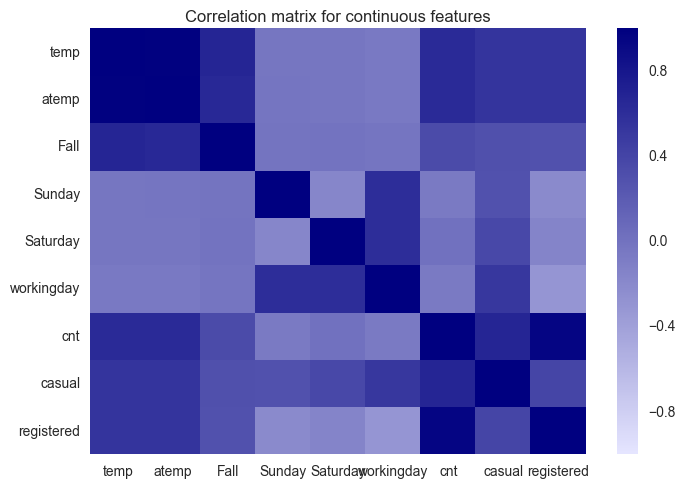

In [39]:
blu = sns.light_palette("navy", as_cmap= True)
sns.heatmap(df_allvalues[correlation_dataframe[correlation_dataframe.apply(more_than_60_percent).sum() > 1].index].corr(),cmap= blu, fmt="%d")
plt.title("Correlation matrix for continuous features")

so the next obvious correlation is 'temp' or 'atemp' with 'cnt', 'registered' or 'casual'. 

### **A3 - _First round model testing_**

Let us first fix once for all a randomly selected evaluation set of size 0.1 

In [46]:
X = pd.concat([cont_features, dummy_features],axis = 1)
y_day = df_day['cnt']
y_day_cas = df_day['casual']
y_day_reg = df_day['registered']
X_work, X_eval, y_work, y_eval = train_test_split(X,y_day , test_size = 0.1, random_state=3)
X_work, X_eval, y_work_cas, y_eval_cas = train_test_split(X,y_day , test_size = 0.1, random_state=3)
X_work, X_eval, y_work_reg, y_eval_reg = train_test_split(X,y_day , test_size = 0.1, random_state=3)

In [41]:
X_work.index

Int64Index([469, 639, 445, 470, 123, 127, 407,  31,  10, 143,
            ...
            422, 119, 650, 681, 714, 659, 256, 643, 249, 664],
           dtype='int64', length=657)

In [42]:
y_work.index

Int64Index([469, 639, 445, 470, 123, 127, 407,  31,  10, 143,
            ...
            422, 119, 650, 681, 714, 659, 256, 643, 249, 664],
           dtype='int64', length=657)

In [43]:
y_work_cas.index

Int64Index([469, 639, 445, 470, 123, 127, 407,  31,  10, 143,
            ...
            422, 119, 650, 681, 714, 659, 256, 643, 249, 664],
           dtype='int64', length=657)

In [44]:
y_work_reg.index

Int64Index([469, 639, 445, 470, 123, 127, 407,  31,  10, 143,
            ...
            422, 119, 650, 681, 714, 659, 256, 643, 249, 664],
           dtype='int64', length=657)

Now that we have set aside a random 10% subset of the dataset, we will test our models via cross-validation simply due to the small size of the dataset where outliers might have too much of an impact. 

In [45]:
folds = 3

for i, (train_idx, test_idx) in enumerate(KFold(len(X_work),folds, shuffle=True)):    
    
    train = X_work.index[train_idx]
    test = X_work.index[test_idx]
    
    #linear models
    lr = LinearRegression().fit(X_work.loc[train],y_work.loc[train])
    ridge = Ridge().fit(X_work.loc[train],y_work.loc[train])
    elastic = ElasticNet().fit(X_work.loc[train],y_work.loc[train])
    
    # KNN
    KNN = KNeighborsRegressor().fit(X_work.loc[train],y_work.loc[train])
    
    #Tree-models
    RFR = RandomForestRegressor().fit(X_work.loc[train],y_work.loc[train])
    GBR = GradientBoostingRegressor().fit(X_work.loc[train],y_work.loc[train])
    
    print("Evaluation on fold ", i)
    print("MAE for Linear Regression: ", "train", mean_absolute_error(y_work.loc[train], lr.predict(X_work.loc[train])),"test",mean_absolute_error(y_work.loc[test], lr.predict(X_work.loc[test])))
    print("MAE for Ridge Regression: ", "train", mean_absolute_error(y_work.loc[train], ridge.predict(X_work.loc[train])), "test", mean_absolute_error(y_work.loc[test], ridge.predict(X_work.loc[test])))
    print("MAE for ElasticNet: ", "train", mean_absolute_error(y_work.loc[train], elastic.predict(X_work.loc[train])), "test",mean_absolute_error(y_work.loc[test], elastic.predict(X_work.loc[test])))
    print("MAE for KNN Regressor: ", "train", mean_absolute_error(y_work.loc[train], KNN.predict(X_work.loc[train])), "test",mean_absolute_error(y_work.loc[test], KNN.predict(X_work.loc[test])))
    print("MAE for Random Forest Regressor: ", "train",mean_absolute_error(y_work.loc[train], RFR.predict(X_work.loc[train])) , "test",mean_absolute_error(y_work.loc[test], RFR.predict(X_work.loc[test])))
    print("MAE for Gradient Boosting Regressor: ","train",mean_absolute_error(y_work.loc[train], GBR.predict(X_work.loc[train])) , "test", mean_absolute_error(y_work.loc[test], GBR.predict(X_work.loc[test])))
    print("-----------------------------------------")

Evaluation on fold  0
MAE for Linear Regression:  train 549.301369863 test 591.187214612
MAE for Ridge Regression:  train 545.32484395 test 605.400033757
MAE for ElasticNet:  train 1038.87803375 test 1064.68220247
MAE for KNN Regressor:  train 517.7 test 680.823744292
MAE for Random Forest Regressor:  train 202.685388128 test 494.681278539
MAE for Gradient Boosting Regressor:  train 277.747220314 test 446.216699385
-----------------------------------------
Evaluation on fold  1
MAE for Linear Regression:  train 527.474885845 test 621.333333333
MAE for Ridge Regression:  train 530.898942957 test 614.841233052
MAE for ElasticNet:  train 1061.10230994 test 1045.71071403
MAE for KNN Regressor:  train 526.922374429 test 689.051141553
MAE for Random Forest Regressor:  train 204.546575342 test 514.196347032
MAE for Gradient Boosting Regressor:  train 257.80647385 test 485.986964707
-----------------------------------------
Evaluation on fold  2
MAE for Linear Regression:  train 553.957762557 

We can see that random forest and gradient boosting are performing the best while still completely overfitting. The gap between training and test performance leaves a lot of hope for improvement through hyperparamater tuning. The next step would be to perform grid search for hyperparamater optimization. But before let us have a look at the 'casual' and 'registered' labels.  

In [46]:
folds = 3

for i, (train_idx, test_idx) in enumerate(KFold(len(X_work),folds, shuffle=True)):    
    
    train = X_work.index[train_idx]
    test = X_work.index[test_idx]
    
    #linear models
    lr_cas = LinearRegression().fit(X_work.loc[train],y_work_cas.loc[train])
    ridge_cas = Ridge().fit(X_work.loc[train],y_work_cas.loc[train])
    elastic_cas = ElasticNet().fit(X_work.loc[train],y_work_cas.loc[train])
    
    # KNN
    KNN_cas = KNeighborsRegressor().fit(X_work.loc[train],y_work_cas.loc[train])
    
    #Tree-models
    RFR_cas = RandomForestRegressor().fit(X_work.loc[train],y_work_cas.loc[train])
    GBR_cas = GradientBoostingRegressor().fit(X_work.loc[train],y_work_cas.loc[train])
    
    print("Evaluation on fold ", i)
    print("casual MAE for Linear Regression: ", "train", mean_absolute_error(y_work_cas.loc[train], lr_cas.predict(X_work.loc[train])),"test",mean_absolute_error(y_work_cas.loc[test], lr_cas.predict(X_work.loc[test])))
    print("casual MAE for Ridge Regression: ", "train", mean_absolute_error(y_work_cas.loc[train], ridge_cas.predict(X_work.loc[train])), "test", mean_absolute_error(y_work_cas.loc[test], ridge_cas.predict(X_work.loc[test])))
    print("casual MAE for ElasticNet: ", "train", mean_absolute_error(y_work_cas.loc[train], elastic_cas.predict(X_work.loc[train])), "test",mean_absolute_error(y_work_cas.loc[test], elastic_cas.predict(X_work.loc[test])))
    print("casual MAE for KNN Regressor: ", "train", mean_absolute_error(y_work_cas.loc[train], KNN_cas.predict(X_work.loc[train])), "test",mean_absolute_error(y_work_cas.loc[test], KNN_cas.predict(X_work.loc[test])))
    print("casual MAE for Random Forest Regressor: ", "train",mean_absolute_error(y_work_cas.loc[train], RFR_cas.predict(X_work.loc[train])) , "test",mean_absolute_error(y_work_cas.loc[test], RFR_cas.predict(X_work.loc[test])))
    print("casual MAE for Gradient Boosting Regressor: ","train",mean_absolute_error(y_work_cas.loc[train], GBR_cas.predict(X_work.loc[train])) , "test", mean_absolute_error(y_work_cas.loc[test], GBR_cas.predict(X_work.loc[test])))
    print("-----------------------------------------")

Evaluation on fold  0
casual MAE for Linear Regression:  train 572.835616438 test 541.799086758
casual MAE for Ridge Regression:  train 575.14258494 test 539.173043729
casual MAE for ElasticNet:  train 1058.70088092 test 1071.76855184
casual MAE for KNN Regressor:  train 543.384474886 test 618.644748858
casual MAE for Random Forest Regressor:  train 203.673287671 test 494.870776256
casual MAE for Gradient Boosting Regressor:  train 283.489342443 test 483.509265353
-----------------------------------------
Evaluation on fold  1
casual MAE for Linear Regression:  train 520.746009657 test 636.263339126
casual MAE for Ridge Regression:  train 522.52734263 test 642.224513427
casual MAE for ElasticNet:  train 1034.6932552 test 1089.29181246
casual MAE for KNN Regressor:  train 543.526940639 test 655.655707763
casual MAE for Random Forest Regressor:  train 196.00913242 test 557.057077626
casual MAE for Gradient Boosting Regressor:  train 267.553460162 test 477.411073739
----------------------

In [47]:
folds = 3

for i, (train_idx, test_idx) in enumerate(KFold(len(X_work),folds, shuffle=True)):    
    
    train = X_work.index[train_idx]
    test = X_work.index[test_idx]
    
    #linear models
    lr_reg = LinearRegression().fit(X_work.loc[train],y_work_reg.loc[train])
    ridge_reg = Ridge().fit(X_work.loc[train],y_work_reg.loc[train])
    elastic_reg = ElasticNet().fit(X_work.loc[train],y_work_reg.loc[train])
    
    # KNN
    KNN_reg = KNeighborsRegressor().fit(X_work.loc[train],y_work_reg.loc[train])
    
    #Tree-models
    RFR_reg = RandomForestRegressor().fit(X_work.loc[train],y_work_reg.loc[train])
    GBR_reg = GradientBoostingRegressor().fit(X_work.loc[train],y_work_reg.loc[train])
    
    print("Evaluation on fold ", i)
    print("registered MAE for Linear Regression: ", "train", mean_absolute_error(y_work_reg.loc[train], lr_reg.predict(X_work.loc[train])),"test",mean_absolute_error(y_work_reg.loc[test], lr_reg.predict(X_work.loc[test])))
    print("registered MAE for Ridge Regression: ", "train", mean_absolute_error(y_work_reg.loc[train], ridge_reg.predict(X_work.loc[train])), "test", mean_absolute_error(y_work_reg.loc[test], ridge_reg.predict(X_work.loc[test])))
    print("registered MAE for ElasticNet: ", "train", mean_absolute_error(y_work_reg.loc[train], elastic_reg.predict(X_work.loc[train])), "test",mean_absolute_error(y_work_reg.loc[test], elastic_reg.predict(X_work.loc[test])))
    print("registered MAE for KNN Regressor: ", "train", mean_absolute_error(y_work_reg.loc[train], KNN_reg.predict(X_work.loc[train])), "test",mean_absolute_error(y_work_reg.loc[test], KNN_reg.predict(X_work.loc[test])))
    print("registered MAE for Random Forest Regressor: ", "train",mean_absolute_error(y_work_reg.loc[train], RFR_reg.predict(X_work.loc[train])) , "test",mean_absolute_error(y_work_reg.loc[test], RFR_reg.predict(X_work.loc[test])))
    print("registered MAE for Gradient Boosting Regressor: ","train",mean_absolute_error(y_work_reg.loc[train], GBR_reg.predict(X_work.loc[train])) , "test", mean_absolute_error(y_work_reg.loc[test], GBR_reg.predict(X_work.loc[test])))
    print("-----------------------------------------")

Evaluation on fold  0
registered MAE for Linear Regression:  train 557.822148544 test 585.708431888
registered MAE for Ridge Regression:  train 559.782778615 test 585.701478545
registered MAE for ElasticNet:  train 1055.05040327 test 1034.62333152
registered MAE for KNN Regressor:  train 566.615068493 test 667.993607306
registered MAE for Random Forest Regressor:  train 206.592237443 test 506.350228311
registered MAE for Gradient Boosting Regressor:  train 267.686576014 test 457.386594235
-----------------------------------------
Evaluation on fold  1
registered MAE for Linear Regression:  train 493.439060886 test 682.69987827
registered MAE for Ridge Regression:  train 496.611704803 test 676.637766781
registered MAE for ElasticNet:  train 1030.70783559 test 1137.74452784
registered MAE for KNN Regressor:  train 491.850684932 test 727.226484018
registered MAE for Random Forest Regressor:  train 193.419634703 test 546.180365297
registered MAE for Gradient Boosting Regressor:  train 274.

### hyperparamter tuning 

From now on let us only work with **random forest** and **gradient boosting**, and let us try to find the best hyperparameters. As we will still modify our dataset via feature engineering and outlier removal, the main goal is just have an idea for the optimal range for each hyperparameter in order to reduce overfitting as opposed to finding the exact best value. By experience we would expect that **gradient boosting** will be able to perform slightly better than random forest, (at the cost of being slower to train).    

Main parameter for **gradient boosting**: `n_estimators`, `learning_rate` and maybe a pre-pruning option such as `max_depth`. 

Main parameter for **random forest**: `n_estimators`, `max_features` (usually to be taken as the square root of the number of features) and the pre-pruning option `max_depth`. 

Gradient boosting is more sensitive to parameter setting than random forest, but if done correctly provides better results.

`learning_rate` controls how much each tree is allowed to correct the mistakes of the previous tree. Lowering `learning_rate` means more trees are needed to build model of similar complexity.  

### Random Forest 

### Gradient Boosting

In [ ]:
best_score = 2000

for n_estimators in [1000,1500,2000,2500]:
    for learning_rate in [0.001, 0.01, 0.1 , 1]:
        for max_depth in [1,2,3,4]:
        
            score = 0
            for i, (train_idx, test_idx) in enumerate(KFold(len(X_work),folds, shuffle=True)): 
                train = X_work.index[train_idx]
                test = X_work.index[test_idx]
                GBR = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, criterion='mae').fit(X_work.loc[train], y_work.loc[train])
                score = score + mean_absolute_error(y_work.loc[test], GBR.predict(X_work.loc[test]))
                MAE = score/3 
        
                if MAE < best_score: 
                    best_score = MAE
                    best_parameters = {'learning_rate': learning_rate, 'n_estimtors': n_estimators, 'max_depth': max_depth}

print("best score:", best_score)
print("best parameters: ", best_parameters)

let us now look at the 'casual' data

In [ ]:
best_score = 2000

for n_estimators in [2000,2500,3000]:
    for learning_rate in [ 0.01, 0.1 , 1]:
        for max_depth in [2,3,4]:
            score = 0
            for i, (train_idx, test_idx) in enumerate(KFold(len(X_work),folds, shuffle=True)):  
                train = X_work.index[train_idx]
                test = X_work.index[test_idx]
                GBR = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate = learning_rate,max_depth = max_depth).fit(X_work.loc[train], y_work_cas.loc[train])
                score = score + mean_absolute_error(y_work_cas.loc[test], GBR.predict(X_work.loc[test]))
                MAE = score/3 
        
                if MAE < best_score: 
                    best_score = MAE
                    best_parameters = {'learning_rate': learning_rate, 'n_estimtors': n_estimators, 'max_depth': max_depth}

print("best score:", best_score)
print("best parameters: ", best_parameters)

let us look at the 'registered' data

In [88]:
best_score = 2000

for n_estimators in [1000,1500,2000,2500]:
    for learning_rate in [ 0.01, 0.1 , 1]:
        for max_depth in [2,3,4]:
            score = 0
            for i, (train_idx, test_idx) in enumerate(KFold(len(X_work),folds, shuffle=True)): 
                train = X_work.index[train_idx]
                test = X_work.index[test_idx]
                GBR = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate = learning_rate,max_depth = max_depth).fit(X_work.loc[train], y_work_reg.loc[train])
                score = score + mean_absolute_error(y_work_reg.loc[test], GBR.predict(X_work.loc[test]))
                MAE = score/3 
        
                if MAE < best_score: 
                    best_score = MAE
                    best_parameters = {'learning_rate': learning_rate, 'n_estimtors': n_estimators, 'max_depth': max_depth}

print("best score:", best_score)
print("best parameters: ", best_parameters)

best score: 147.708048894
best parameters:  {'n_estimtors': 1000, 'max_depth': 3, 'learning_rate': 0.01}


# B - Second round

## B1 - Outlier detection

In [48]:
clf = IsolationForest(n_estimators = 2000, random_state=5)
clf.fit(X)
outliers = X.index[clf.predict(X)== -1]


In [49]:
outliers

Int64Index([  7,   8,  16,  25,  35,  49,  51,  64,  68,  85,  89, 104, 105,
            149, 169, 183, 184, 238, 247, 248, 249, 250, 266, 267, 282, 284,
            291, 301, 314, 319, 324, 325, 327, 339, 340, 350, 359, 366, 368,
            380, 385, 386, 399, 406, 407, 414, 415, 449, 471, 477, 513, 550,
            567, 568, 596, 603, 609, 610, 611, 640, 646, 666, 667, 672, 681,
            691, 693, 700, 707, 708, 721, 724, 725, 728],
           dtype='int64')

In [50]:
len(X.index[outliers])

74

In [51]:
df_day['dteday'][X.index[outliers]]

7      2011-01-08
8      2011-01-09
16     2011-01-17
25     2011-01-26
35     2011-02-05
49     2011-02-19
51     2011-02-21
64     2011-03-06
68     2011-03-10
85     2011-03-27
89     2011-03-31
104    2011-04-15
105    2011-04-16
149    2011-05-30
169    2011-06-19
183    2011-07-03
184    2011-07-04
238    2011-08-27
247    2011-09-05
248    2011-09-06
249    2011-09-07
250    2011-09-08
266    2011-09-24
267    2011-09-25
282    2011-10-10
284    2011-10-12
291    2011-10-19
301    2011-10-29
314    2011-11-11
319    2011-11-16
          ...    
407    2012-02-12
414    2012-02-19
415    2012-02-20
449    2012-03-25
471    2012-04-16
477    2012-04-22
513    2012-05-28
550    2012-07-04
567    2012-07-21
568    2012-07-22
596    2012-08-19
603    2012-08-26
609    2012-09-01
610    2012-09-02
611    2012-09-03
640    2012-10-02
646    2012-10-08
666    2012-10-28
667    2012-10-29
672    2012-11-03
681    2012-11-12
691    2012-11-22
693    2012-11-24
700    2012-12-01
707    201

## B2 - Second round model testing

In [95]:
best_score = 2000

for n_estimators in [1000,1500,2000,2500]:
    for learning_rate in [0.001, 0.01, 0.1 , 1]:
        for max_depth in [1,2,3,4]:
        
            score = 0
            for i, (train_idx, test_idx) in enumerate(KFold(len(X_work),folds, shuffle=True)): 
                train = X_work.index[train_idx]
                new_train = X_work.index[[val for val in train_idx if val not in outliers]]
                test = X_work.index[test_idx]
                new_test = X_work.index[[val for val in test_idx if val not in outliers]]
                GBR = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth).fit(X_work.loc[new_train], y_work.loc[new_train])
                score = score + mean_absolute_error(y_work.loc[test], GBR.predict(X_work.loc[test]))
                MAE = score/3 
        
                if MAE < best_score: 
                    best_score = MAE
                    best_parameters = {'learning_rate': learning_rate, 'n_estimtors': n_estimators, 'max_depth': max_depth}

print("best score:", best_score)
print("best parameters: ", best_parameters)

best score: 155.049204177
best parameters:  {'n_estimtors': 2500, 'max_depth': 3, 'learning_rate': 0.01}


'casual'

In [96]:
best_score = 2000

for n_estimators in [1000,1500,2000,2500]:
    for learning_rate in [0.001, 0.01, 0.1 , 1]:
        for max_depth in [1,2,3,4]:
        
            score = 0
            for i, (train_idx, test_idx) in enumerate(KFold(len(X_work),folds, shuffle=True)): 
                train = X_work.index[train_idx]
                new_train = X_work.index[[val for val in train_idx if val not in outliers]]
                test = X_work.index[test_idx]
                new_test = X_work.index[[val for val in test_idx if val not in outliers]]
                GBR_cas = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth).fit(X_work.loc[new_train], y_work_cas.loc[new_train])
                score = score + mean_absolute_error(y_work_cas.loc[test], GBR_cas.predict(X_work.loc[test]))
                MAE = score/3 
        
                if MAE < best_score: 
                    best_score = MAE
                    best_parameters = {'learning_rate': learning_rate, 'n_estimtors': n_estimators, 'max_depth': max_depth}

print("best score:", best_score)
print("best parameters: ", best_parameters)

best score: 149.373673647
best parameters:  {'n_estimtors': 2000, 'max_depth': 4, 'learning_rate': 0.01}


In [97]:
best_score = 2000

for n_estimators in [1000,1500,2000,2500]:
    for learning_rate in [0.001, 0.01, 0.1 , 1]:
        for max_depth in [1,2,3,4]:
        
            score = 0
            for i, (train_idx, test_idx) in enumerate(KFold(len(X_work),folds, shuffle=True)): 
                train = X_work.index[train_idx]
                new_train = X_work.index[[val for val in train_idx if val not in outliers]]
                test = X_work.index[test_idx]
                new_test = X_work.index[[val for val in test_idx if val not in outliers]]
                GBR_reg = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth).fit(X_work.loc[new_train], y_work_reg.loc[new_train])
                score = score + mean_absolute_error(y_work_reg.loc[test], GBR_reg.predict(X_work.loc[test]))
                MAE = score/3 
        
                if MAE < best_score: 
                    best_score = MAE
                    best_parameters = {'learning_rate': learning_rate, 'n_estimtors': n_estimators, 'max_depth': max_depth}

print("best score:", best_score)
print("best parameters: ", best_parameters)

best score: 155.046913869
best parameters:  {'n_estimtors': 1500, 'max_depth': 3, 'learning_rate': 0.01}


outlier removal doesnt really help that much

# C - Third round 

## C1 -  Feature engineering

### augmenting continuous features

In [35]:
def exp_transform(some_array):
    return np.exp(some_array)-1

def log_transform(some_array):
    return np.log(some_array + 1)

In [36]:
cont_features= df_day[['temp', 'atemp', 'hum', 'windspeed']]

In [37]:
df_day['exp temp'] = exp_transform(df_day['temp'])
df_day['exp atemp'] = exp_transform(df_day['atemp'])
df_day['exp hum'] = exp_transform(df_day['hum'])
df_day['exp windspeed'] = exp_transform(df_day['windspeed'])
exp_features = df_day[['exp temp','exp atemp','exp hum','exp windspeed']]

In [38]:
df_day['log temp'] = log_transform(df_day['temp'])
df_day['log atemp'] = log_transform(df_day['atemp'])
df_day['log hum'] = log_transform(df_day['hum'])
df_day['log windspeed'] = log_transform(df_day['windspeed'])
log_features = df_day[['log temp','log atemp','log hum','log windspeed']]

In [39]:
df_day['temp^2'] = np.square(df_day['temp'])
df_day['atemp^2'] = np.square(df_day['atemp'])
df_day['hum^2'] = np.square(df_day['hum'])
df_day['windspeed^2'] = np.square(df_day['windspeed'])
square_features = df_day[['temp^2','atemp^2','hum^2','windspeed^2']]

In [40]:
df_day['sqrt temp'] = np.sqrt(df_day['temp'])
df_day['sqrt atemp'] = np.sqrt(df_day['atemp'])
df_day['sqrt hum'] = np.sqrt(df_day['hum'])
df_day['sqrt windspeed'] = np.sqrt(df_day['windspeed'])
sqrt_features = df_day[['sqrt temp','sqrt atemp','sqrt hum','sqrt windspeed']]

In [48]:
X_aug = pd.concat([cont_features,exp_features,log_features,square_features,sqrt_features,dummy_features],axis=1).loc[X_work.index]

## label transform 

it is pretty standard idea to transform count data via the log transform $\log(y+1)$, as it tends to resemble a Poisson distribution. 

In [106]:
y_work_log = y_work.apply(log_transform)
y_work_reg_log = y_work_reg.apply(log_transform)
y_work_cas_log = y_work_cas.apply(log_transform)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X_day,exp_transform(y_day_cas), test_size=0.1, random_state=3)

In [112]:
best_score = 2000

for n_estimators in [1500,2000,2500,3000]:
    for learning_rate in [0.001, 0.01, 0.1 , 1]:
        for max_depth in [3,4,5]:
        
            score = 0
            for i, (train_idx, test_idx) in enumerate(KFold(len(X_work),folds, shuffle=True)): 
                train = X_work.index[train_idx]
                test = X_work.index[test_idx]
                GBR = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth).fit(X_work.loc[train], y_work_log.loc[train])
                score = score + mean_absolute_error(y_work.loc[test], np.apply_along_axis(exp_transform, axis= 0, arr = GBR.predict(X_work.loc[test])))
                MAE = score/3 
        
                if MAE < best_score: 
                    best_score = MAE
                    best_parameters = {'learning_rate': learning_rate, 'n_estimtors': n_estimators, 'max_depth': max_depth}

print("best score:", best_score)
print("best parameters: ", best_parameters)

best score: 154.837550578
best parameters:  {'n_estimtors': 2000, 'max_depth': 4, 'learning_rate': 0.01}


## lasso feature selection

In [49]:
score = 0
folds = 3

for i, (train_idx, test_idx) in enumerate(KFold(len(X_aug),folds, shuffle=True)): 
    train = X_aug.index[train_idx]
    test = X_aug.index[test_idx]
    lasso_100 = Lasso(alpha=100,max_iter = 1000000).fit(X_aug.loc[train],y_work.loc[train])
    lasso_10 = Lasso(alpha=10,max_iter = 1000000).fit(X_aug.loc[train],y_work.loc[train])
    lasso_1 = Lasso(alpha=1,max_iter = 1000000).fit(X_aug.loc[train],y_work.loc[train])
    lasso_01 = Lasso(alpha=0.1,max_iter = 1000000).fit(X_aug.loc[train],y_work.loc[train])
    lasso_001 = Lasso(alpha=0.01,max_iter = 1000000).fit(X_aug.loc[train],y_work.loc[train])
    lasso_0001 = Lasso(alpha=0.001,max_iter = 1000000).fit(X_aug.loc[train],y_work.loc[train])


    print("alpha = 100 - test set MAE: %.2f" % mean_absolute_error(y_work.loc[test], lasso_100.predict(X_aug.loc[test])))
    print("alpha = 100 - number of features used: %d" % np.sum(lasso_100.coef_ !=0))
    print("alpha = 100 - features at play:", X_aug.columns[lasso_100.coef_ !=0])
    print("alpha = 100 - corresponding coefficients: ", lasso_100.coef_[lasso_100.coef_ !=0])
    print("---------------------------")

    print("alpha = 10 - test set MAE: %.2f" % mean_absolute_error(y_work.loc[test], lasso_10.predict(X_aug.loc[test])))
    print("alpha = 10 - number of features used: %d" % np.sum(lasso_10.coef_ !=0))
    print("alpha = 10 - features at play:", X_aug.columns[lasso_10.coef_ !=0])
    print("alpha = 10 - corresponding coefficients: ", lasso_10.coef_[lasso_10.coef_ !=0])
    print("---------------------------")

    print("alpha = 1 - test set MAE: %.2f" % mean_absolute_error(y_work.loc[test], lasso_1.predict(X_aug.loc[test])))
    print("alpha = 1 - number of features used: %d" % np.sum(lasso_1.coef_ !=0))
    print("alpha = 1 - features at play:", X_aug.columns[lasso_1.coef_ !=0])
    print("alpha = 1 - corresponding coefficients: ", lasso_1.coef_[lasso_1.coef_ !=0])
    print("---------------------------")
    
    print("alpha = 0.1 - test set MAE: %.2f" % mean_absolute_error(y_work.loc[test], lasso_01.predict(X_aug.loc[test])))
    print("alpha = 0.1 - number of features used: %d" % np.sum(lasso_01.coef_ !=0))
    print("alpha = 0.1 - features at play:", X_aug.columns[lasso_01.coef_ !=0])
    print("alpha = 0.1 - corresponding coefficients: ", lasso_01.coef_[lasso_01.coef_ !=0])
    print("---------------------------")
    

    print("alpha = 0.01 - test set MAE: %.2f" % mean_absolute_error(y_work.loc[test], lasso_001.predict(X_aug.loc[test])))
    print("alpha = 0.01 - number of features used: %d" % np.sum(lasso_001.coef_ !=0))
    print("alpha = 0.01 - features at play:", X_aug.columns[lasso_001.coef_ !=0])
    print("alpha = 0.01 - corresponding coefficients: ", lasso_001.coef_[lasso_001.coef_ !=0])
    print("---------------------------")

    print("alpha = 0.001 - test set MAE: %.2f" % mean_absolute_error(y_work.loc[test], lasso_0001.predict(X_aug.loc[test])))
    print("alpha = 0.001 - number of features used: %d" % np.sum(lasso_0001.coef_ !=0))
    print("alpha = 0.001 - features at play:", X_aug.columns[lasso_0001.coef_ !=0])
    print("alpha = 0.001 - corresponding coefficients: ", lasso_0001.coef_[lasso_0001.coef_ !=0])

/Users/giancarlokerg/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha = 100 - test set MAE: 721.47
alpha = 100 - number of features used: 4
alpha = 100 - features at play: Index(['exp temp', 'Spring', 'year 2011', 'weathersit 1'], dtype='object')
alpha = 100 - corresponding coefficients:  [ 1395.84893345 -1425.95705917 -1850.06281204   397.3265658 ]
---------------------------
alpha = 10 - test set MAE: 570.18
alpha = 10 - number of features used: 21
alpha = 10 - features at play: Index(['exp atemp', 'exp hum', 'exp windspeed', 'Spring', 'Summer', 'Fall',
       'Winter', 'year 2011', 'Jan', 'Mar', 'May', 'Jul', 'Sep', 'Oct',
       'Sunday', 'Monday', 'Friday', 'workingday', 'non workingday',
       'weathersit 1', 'weathersit 3'],
      dtype='object')
alpha = 10 - corresponding coefficients:  [  2.84573689e+03  -4.92480839e+02  -1.26537814e+03  -1.23091469e+03
   3.81414754e+01  -6.46972902e+00   2.34845392e+02  -2.03918094e+03
  -1.36180318e+02   2.99847091e+02   5.29632978e+01  -2.40204544e+02
   6.29940889e+02   4.54853349e+02  -2.31285557e+0

.

/Users/giancarlokerg/anaconda/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 59 iterations, alpha=7.602e+02, previous alpha=1.347e+00, with an active set of 30 regressors.
  ConvergenceWarning)


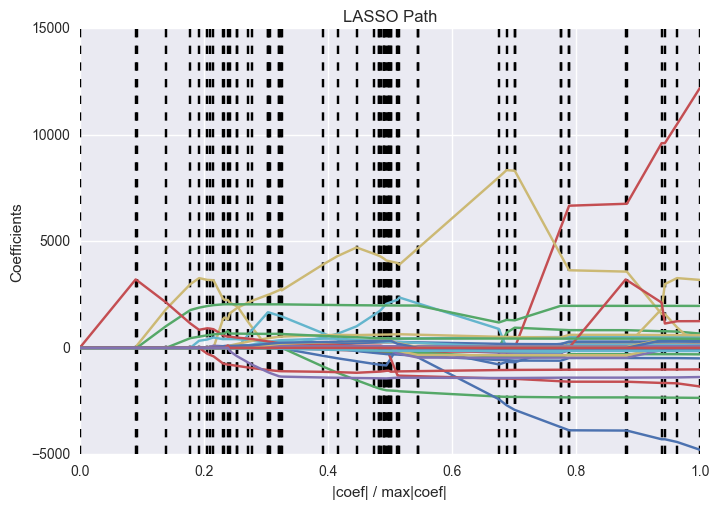

In [52]:
alphas, _, coefs = lm.lars_path(np.array(X_aug), np.array(y_work), method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

#  D - Fourth round

## D1 - Dataset augmentation  

In this section we are going to add some features for both the daily as well as the hourly dataset. The new features will be 1) the daylight timespan for the daily data set and 2) the brightness factor for each hour in the hourly dataset. the data is pulled for Washington DC.  
source: http://aa.usno.navy.mil/data/docs/RS_OneYear.php 

In [61]:
df_2011 = pd.read_table("sunrise_sunset_2011.txt", delim_whitespace=True, dtype = 'str') 
df_2012 = pd.read_table("sunrise_sunset_2012.txt", delim_whitespace=True, dtype = 'str') 

In [62]:
df_2012.head()

,Day,Rise_1,Set_1,Rise_2,Set_2,Rise_3,Set_3,Rise_4,Set_4,Rise_5,...,Rise_8,Set_8,Rise_9,Set_9,Rise_10,Set_10,Rise_11,Set_11,Rise_12,Set_12
0,01,0727,1657,0715,1729,0640,1801,0552,1832,0510,...,0510,1919,0537,1838,0604,1750,0636,1707,0708,1646
1,02,0727,1657,0714,1730,0638,1802,0551,1833,0509,...,0510,1918,0538,1836,0605,1749,0637,1706,0709,1646
2,03,0727,1658,0713,1731,0637,1803,0549,1834,0507,...,0511,1917,0539,1835,0606,1747,0638,1705,0710,1646
3,04,0727,1659,0712,1732,0635,1805,0547,1835,0506,...,0512,1915,0540,1833,0607,1745,0639,1704,0711,1646
4,05,0727,1700,0711,1734,0634,1806,0546,1836,0505,...,0513,1914,0541,1831,0608,1744,0640,1703,0712,1646


### Augmenting the daily dataset

In [32]:
start_date = datetime.date(2011, 1, 1)
end_date   = datetime.date(2013, 1, 1)

dates_2011_2012 = [ start_date + datetime.timedelta(n) for n in range(int ((end_date - start_date).days))]

In [33]:
df = pd.DataFrame(dates_2011_2012, columns= ['date'])

In [67]:
def get_day(date):
    return date.day
def get_month(date):
    return date.month
def get_year(date):
    return date.year
def get_isoformat(date):
    return date.isoformat()

In [68]:
df['day'] = df['date'].apply(get_day)
df['mnth'] = df['date'].apply(get_month)
df['year'] = df['date'].apply(get_year)
df['dteday'] = df['date'].apply(get_isoformat)

In [69]:
df.head()

,date,day,mnth,year,dteday
0,2011-01-01,1,1,2011,2011-01-01
1,2011-01-02,2,1,2011,2011-01-02
2,2011-01-03,3,1,2011,2011-01-03
3,2011-01-04,4,1,2011,2011-01-04
4,2011-01-05,5,1,2011,2011-01-05


In [70]:
for j in range(12):
    index_list_2011 = df[(df['mnth']== (j+1))&(df['year']==2011)].index.get_values()
    index_list_2012 = df[(df['mnth']== (j+1))&(df['year']==2012)].index.get_values()
    
    for k,i in enumerate(index_list_2011):
        df.loc[i,'Rise'] = df_2011['Rise_'+str(j+1)][k] 
        df.loc[i,'Set'] = df_2011['Set_'+str(j+1)][k]
        
    for k,i in enumerate(index_list_2012):
        df.loc[i,'Rise'] = df_2012['Rise_'+str(j+1)][k] 
        df.loc[i,'Set'] = df_2012['Set_'+str(j+1)][k]

In [71]:
def str_to_datetime(time):
    return datetime.time(hour = int(time[0:2]), minute = int(time[2:5]))
def convert_to_minutes(time):
    t= datetime.time(hour = int(time[0:2]), minute = int(time[2:5]))
    return t.hour*60 + t.minute

In [72]:
df['Rise datetime']=df['Rise'].apply(str_to_datetime)
df['Set datetime']=df['Set'].apply(str_to_datetime)
df['daylight exposure'] = df['Set'].apply(convert_to_minutes)-df['Rise'].apply(convert_to_minutes)

In [74]:
df.head()

,date,day,mnth,year,dteday,Rise,Set,Rise datetime,Set datetime,daylight exposure
0,2011-01-01,1,1,2011,2011-01-01,0727,1657,07:27:00,16:57:00,570
1,2011-01-02,2,1,2011,2011-01-02,0727,1658,07:27:00,16:58:00,571
2,2011-01-03,3,1,2011,2011-01-03,0727,1658,07:27:00,16:58:00,571
3,2011-01-04,4,1,2011,2011-01-04,0727,1659,07:27:00,16:59:00,572
4,2011-01-05,5,1,2011,2011-01-05,0727,1700,07:27:00,17:00:00,573


In [73]:
print("max exposure:", df['daylight exposure'].max(), "- min exposure:",df['daylight exposure'].min())

max exposure: 894 - min exposure: 566


In [88]:
df_day['daylight exposure'] = df['daylight exposure']

### Augmenting the hourly dataset

Sure, we havent really addressed the hourly dataset yet, but we first want to see the benefits on the daily set of adding daylight exposure data. While we are at it we just add the brightness factor as an exercise. In the hope for using it later on if things play out well with daylight exposure. 

In [75]:
start_date_hour = datetime.datetime(2011, 1, 1, 0)
end_date_hour   = datetime.datetime(2013, 1, 1, 0)

In [77]:
m = (end_date_hour.year-start_date_hour.year)*365*24+(end_date_hour.month - start_date_hour.month)*30*24 + (end_date_hour.day - start_date_hour.day)*24+(end_date_hour.hour - start_date_hour.hour)
dates_2011_2012_hour = [ start_date_hour + datetime.timedelta(hours = n) for n in range(m)]
df_hourly = pd.DataFrame(dates_2011_2012_hour, columns= ['date'])

In [78]:
df_hourly.head()

,date
0,2011-01-01 00:00:00
1,2011-01-01 01:00:00
2,2011-01-01 02:00:00
3,2011-01-01 03:00:00
4,2011-01-01 04:00:00


In [79]:
def get_hour(date):
    return date.hour
def get_day(date):
    return date.day
def get_month(date):
    return date.month
def get_year(date):
    return date.year
def get_isoformat(date):
    return date.isoformat()

In [80]:
df_hourly['hour'] = df_hourly['date'].apply(get_hour)
df_hourly['day'] = df_hourly['date'].apply(get_day)
df_hourly['mnth'] = df_hourly['date'].apply(get_month)
df_hourly['year'] = df_hourly['date'].apply(get_year)
df_hourly['dteday'] = df_hourly['date'].apply(get_isoformat)

In [81]:
def brightness(date_time):
    r = df['Rise datetime'][int(df[df['date'] == date_time.date()].index.get_values())]
    s = df['Set datetime'][int(df[df['date'] == date_time.date()].index.get_values())]
    result = 0
    if (date_time.hour == r.hour):
        result = 1-(r.minute /60)
    elif (date_time.hour == s.hour):
        result = s.minute /60
    elif (r.hour< date_time.hour <s.hour):
        result = 1
    else:
        result = 0
    return result

In [86]:
df_hourly['brightness'] = df_hourly['date'].apply(brightness)

In [87]:
df_hourly.head(60)

,date,hour,day,mnth,year,dteday,brightness
0,2011-01-01 00:00:00,0,1,1,2011,2011-01-01T00:00:00,0.000000
1,2011-01-01 01:00:00,1,1,1,2011,2011-01-01T01:00:00,0.000000
2,2011-01-01 02:00:00,2,1,1,2011,2011-01-01T02:00:00,0.000000
3,2011-01-01 03:00:00,3,1,1,2011,2011-01-01T03:00:00,0.000000
4,2011-01-01 04:00:00,4,1,1,2011,2011-01-01T04:00:00,0.000000
5,2011-01-01 05:00:00,5,1,1,2011,2011-01-01T05:00:00,0.000000
6,2011-01-01 06:00:00,6,1,1,2011,2011-01-01T06:00:00,0.000000
7,2011-01-01 07:00:00,7,1,1,2011,2011-01-01T07:00:00,0.550000
8,2011-01-01 08:00:00,8,1,1,2011,2011-01-01T08:00:00,1.000000
9,2011-01-01 09:00:00,9,1,1,2011,2011-01-01T09:00:00,1.000000


## D2 - Fourth round model testing 

In [89]:
X_plus = pd.concat([X, df_day['daylight exposure']],axis=1)

In [ ]:
best_score = 2000

for n_estimators in [1000,1500,2000,2500]:
    for learning_rate in [0.001, 0.01, 0.1 , 1]:
        for max_depth in [1,2,3,4]:
        
            score = 0
            for i, (train_idx, test_idx) in enumerate(KFold(len(X_work),folds, shuffle=True)): 
                train = X_work.index[train_idx]
                test = X_work.index[test_idx]
                GBR = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, criterion='mae').fit(X_plus.loc[train], y_work.loc[train])
                score = score + mean_absolute_error(y_work.loc[test], GBR.predict(X_plus.loc[test]))
                MAE = score/3 
        
                if MAE < best_score: 
                    best_score = MAE
                    best_parameters = {'learning_rate': learning_rate, 'n_estimtors': n_estimators, 'max_depth': max_depth}

print("best score:", best_score)
print("best parameters: ", best_parameters)